In [1]:
# word2vec in numpy according to the lecture
# based on: https://github.com/lazyprogrammer/machine_learning_examples/blob/master/nlp_class2/word2vec.py

In [21]:
# essential stuff
% matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
import pdb
import json
import sys

In [3]:
# for timing
from datetime import datetime

In [4]:
# for the input corpus
from nltk.corpus import brown
sents = brown.sents()
from brown_preprocessing import brown_to_idx

In [5]:
vocab_size = None
keep_words = set([
  'king', 'man', 'queen', 'woman',
  'italy', 'rome', 'france', 'paris',
  'london', 'britain', 'england',
])
indexed_sents, word2idx_lim_vocab, idx2word_lim_vocab = brown_to_idx(vocab_size=vocab_size,keep_words=keep_words)
with open('w2v_word2idx.json', 'w') as f:
    json.dump(word2idx_lim_vocab, f)

number of sentences 57340
49815


cost: 0.69314235273
cost: 0.693097357158
cost: 0.692635272631


<IPython.core.display.Javascript object>


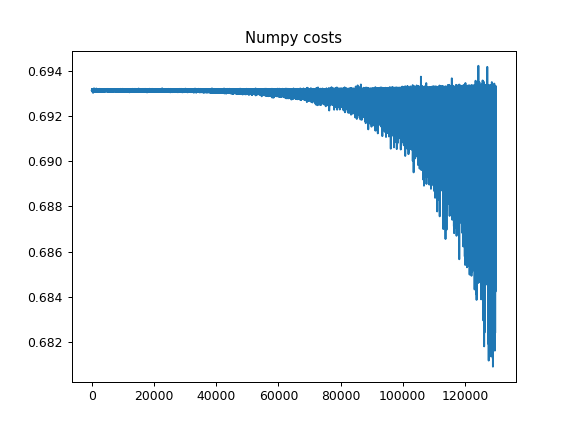

<IPython.core.display.Javascript object>


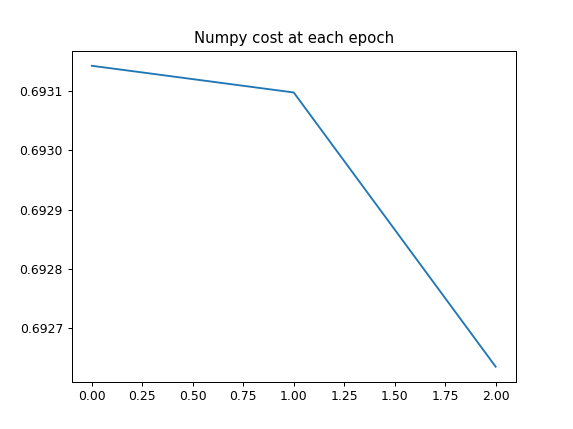

In [27]:
# define custom functions for numpy
def sigmoid(x): #sigmmoid function
    return 1/(1+np.exp(-x))

# initializing the weights
def init_weights(shape):
    return np.random.randn(*shape).astype(np.float32)/np.sqrt(sum(shape)) # denom is sum of fan_in and fan_out

class Model:
    def __init__(self,D,V,context_size):
        self.D = D # embedding dimension (hidden layer size)
        self.V = V # vocabulary size
        self.context_size = context_size # size of the context window
    
    def _get_neg_distr(self,X): # X is the collection of documents
        # helper function to create the distribution for the negative samples
        word2freq ={}
        total_words = 0;
        for x in X:
            for xj in x:
                total_words += 1;
                if xj not in word2freq:
                    word2freq[xj] = 1
                else: word2freq[xj] += 1
        
        neg_distr = np.zeros(self.V).astype(np.float32)
        for i,f in enumerate(word2freq.values()):
            neg_distr[i] = (f*1./total_words) ** 0.75

        self.neg_distr = neg_distr
        pass
    
    def _get_neg_samples(self,context,num_neg_samples):
        # returns the negative samples
        # shorter code: make a copy of the negative distribution.
        # memory efficient code: put zeros in the context of the negative samples
        self.neg_distr_temp = self.neg_distr.copy()
        for cidx in context:
            self.neg_distr_temp[cidx] = 0.
        self.neg_distr_temp = self.neg_distr_temp/self.neg_distr_temp.sum()
        
        neg_samples = np.random.choice(self.V,p=self.neg_distr_temp,size=num_neg_samples,replace=False)
        # choose num_neg_samples from 'V' options, why is replace False though?
        return neg_samples
    def fit(self,X,num_neg_samples = 10,nepochs=100,lr=1e-5,mu=0.99,reg = 0.1):
        N = len(X)
        V = self.V
        D = self.D
        self._get_neg_distr(X)
        context_size = self.context_size
        """
        self.W1 = init_weights((V,D)) # input to hidden weights
        self.W2 = init_weights((D,V)) # hidden to output weights
        """
        self.W1 = init_weights((D,V)) # input to hidden weights
        self.W2 = init_weights((V,D)) # hidden to output weights

        dW1 = np.zeros_like(self.W1) # updates for W1
        dW2 = np.zeros_like(self.W2) # updates for W2
        indices = np.arange(N)
        costs = []
        cost_per_epoch = []
        for epk in range(nepochs):
            np.random.shuffle(indices) # shuffle the indices
            cost_per_epoch_i = []
            for xid in indices:
                x = X[xid] #
                n = len(x)
                if n < 2*context_size + 1:
                    continue
                middle_ix = np.random.choice(n)
                Z = self.W1[:,x[middle_ix]]
                start = max(0,middle_ix - context_size)
                end = min(n-1,middle_ix + context_size + 1)
                context = np.concatenate((x[start:middle_ix],x[middle_ix+1:end]))
                context = np.array(list(set(context)),dtype=np.int32) # to just leave the unique words in the context
                
                # Forward Pass
                
                # positive
                pos_pre = self.W2[context,:].dot(Z)
                pos_pY = sigmoid(pos_pre)
                

                
                #negative
                neg_samples = self._get_neg_samples(context,num_neg_samples)
                neg_pre = self.W2[neg_samples,:].dot(Z)
                neg_pY = sigmoid(-neg_pre)
                
                cost = -np.log(pos_pY).sum() -np.log(neg_pY).sum()
                
                cj = cost/(num_neg_samples + len(context))
                
                # Backward Pass
                #positive
                pos_err = pos_pY - 1
                
                #dW2[:, context] = mu*dW2[:, context] - learning_rate*(np.outer(Z, pos_err) + reg*self.W2[:, context])
                dW2[context,:] = mu * dW2[context,:] - lr*(np.outer(pos_err,Z) + reg*self.W2[context,:])
                
                #negative
                neg_err = neg_pY
                dW2[neg_samples,:] = mu*dW2[neg_samples,:] - lr*(np.outer(neg_err,Z) + reg*self.W2[neg_samples,:])
                
                
                
                # update W2
                self.W2[context,:] += dW2[context,:]
                self.W2[neg_samples,:] += dW2[neg_samples,:]
                
                # update W1
                # gradW1 = pos_err.dot(self.W2[:, context].T) + neg_err.dot(self.W2[:, neg_samples].T)
                grad_W1 = pos_err.dot(self.W2[context,:]) + neg_err.dot(self.W2[neg_samples])
                # dW1[x[jj], :] = mu*dW1[x[jj], :] - learning_rate*(gradW1 + reg*self.W1[x[jj], :])
                
                dW1[:,x[middle_ix]] = mu * dW1[:,x[middle_ix]] - lr*(grad_W1 + reg*self.W1[:,x[middle_ix]])
                
                
                self.W1[:,x[middle_ix]] += dW1[:,x[middle_ix]]
                
                cost_per_epoch_i.append(cj)
                costs.append(cj)
                if xid % 500 == 0:
                    sys.stdout.write("epoch: %d j: %d/ %d cost: %f\r" % (epk, xid, N, cj))
                    sys.stdout.flush()
                pass
            epoch_cost = np.mean(cost_per_epoch_i)
            cost_per_epoch.append(epoch_cost)
            print "cost:", epoch_cost
            pass
        plt.plot(costs)
        plt.title("Numpy costs")
        plt.show()
        
        plt.figure()
        plt.plot(cost_per_epoch)
        plt.title("Numpy cost at each epoch")
        plt.show()
        pass
    
    def test_fn(self):
        # To check the dot function from numpy
        
        D = self.D
        V = self.V
        W1 = init_weights((D,V))
        W2 = init_weights((V,D))
        Z = W1[:,5]
        o_pre = W2.dot(Z)
        print o_pre.shape
        pass

V = len(word2idx_lim_vocab)
model = Model(50, V, 5)
model.fit(indexed_sents, lr=1e-3, mu=0, nepochs=3, num_neg_samples=5)
    
        
                